In [1]:
import numpy as np
import meshpy.triangle as triangle
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

from chp06_utils import *

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib widget

### Define the domain

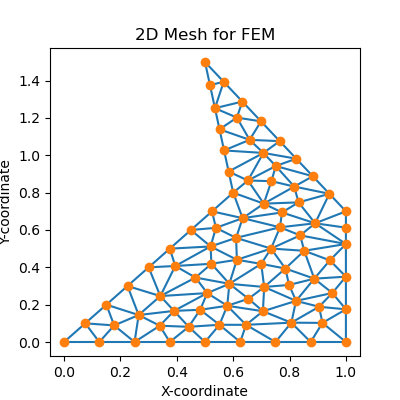

In [2]:
# Define corners of the rectangle
# bc_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
# segments = np.array([[0, 1], [1, 2], [2, 3], [3, 0]])  # edges between points

# bc_points = np.array([[0, 0], [1, 0], [0, 1]])
# segments = np.array([[0, 1], [1, 2], [2, 0]])  # edges between points

bc_points = np.array([[0, 0], [1, 0], [1, 0.7], [0.5, 1.5], [0.6, 0.8]])
segments = np.array([[0, 1], [1, 2], [2, 3], [3,4], [4,0]])  # edges between points

mesh = generate_mesh(bc_points, segments, max_volume=0.008, min_angle=20)
vertices, triangles = extract_mesh_data(mesh)
plot_mesh(vertices, triangles, figsize=(4,4))
#plt.savefig('assets/mesh-complicated.pdf')

### Define the source term in the Poisson's equation

In [3]:
k1 = 1
k2 = 2
f = lambda x : 4*np.pi**2*np.sin(2*np.pi*k1*x[0])*np.sin(2*np.pi*k2*x[1])

# we specify the exact u that we want in order to test our results
ref_u = lambda x : f(x)/4/np.pi**2/(k1**2+k2**2)

### 2D FEM part

In [4]:
def local_stiffness_matrix(pts):
    area = area_of_triangle(pts)
    v1 = pts[0]
    v2 = pts[1]
    v3 = pts[2]
    a = v2 - v1
    b = v3 - v1
    α = a[1]*b[0] - a[0]*b[1] # |alpha|/2 = area
    B = np.array([-(a[1]-b[1])/α, -b[1]/α, a[1]/α])
    C = np.array([(a[0]-b[0])/α, b[0]/α, - a[0]/α])
    
    return (np.outer(B, B) + np.outer(C, C))*area

def FEM_triangular(vertices, triangles, f, verbose=False):
    n = len(vertices)
    A = np.zeros((n,n))
    b = np.zeros(n)
    
    for tri in triangles:
        # update A and b for each triangle.
        pts = vertices[tri]
        locA = local_stiffness_matrix(pts)
        
        f_value = f(sum(pts)/3) # we use the value at the centroid

        for i in range(3):
            for j in range(3):
                A[tri[i], tri[j]] += locA[i, j]
            b[tri[i]] += f_value*area_of_triangle(pts) / 3

    if verbose:       
        print("Without correcting bc, the condition number is {:.2E}".format(np.linalg.cond(A)))

    for idx in range(len(vertices)):
        if check_bc(vertices[idx], bc_points, segments):
            A[idx,:] = 0.0
            A[idx,idx] = 1.0
            b[idx] = ref_u(vertices[idx])
    
    if verbose:
        print("After correcting bc, the condition number is {:.2E}".format(np.linalg.cond(A)))
        
    u = np.linalg.solve(A, b)

    return A, b, u

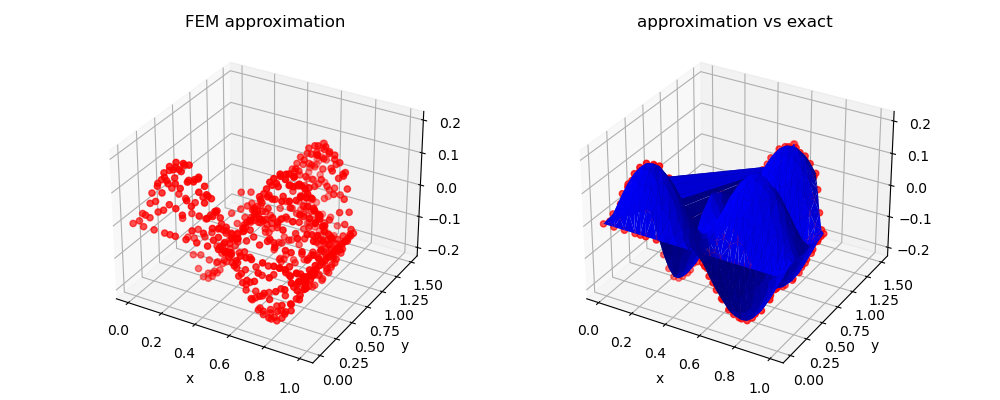

Error is 4.06E-03


In [5]:
mesh = generate_mesh(bc_points, segments, max_volume=0.001, min_angle=20)
vertices, triangles = extract_mesh_data(mesh)
vertices_x = [item[0] for item in vertices]
vertices_y = [item[1] for item in vertices]

# solve the FEM
_, _, u = FEM_triangular(vertices, triangles, f)
# reference value
exact_value = [ref_u(item) for item in vertices]

# plot
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121, projection='3d') 
ax.scatter(vertices_x, vertices_y, u, color='r')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('FEM approximation')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(vertices_x, vertices_y, u, color='r')
ax.plot_trisurf(vertices_x, vertices_y, exact_value, color='b')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('approximation vs exact')

plt.tight_layout()
plt.show()

err = np.max(np.abs(u - exact_value))
print("Error is {:.2E}".format(err))

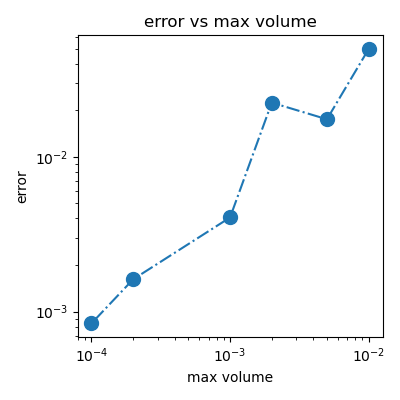

In [6]:
max_volume_list = [0.01, 0.005, 0.002, 0.001, 0.0002, 0.0001]

err_list = np.zeros(len(max_volume_list))
for i in range(len(max_volume_list)):
    max_volume = max_volume_list[i]
    
    mesh = generate_mesh(bc_points, segments, max_volume=max_volume, min_angle=20)
    vertices, triangles = extract_mesh_data(mesh)
    vertices_x = [item[0] for item in vertices]
    vertices_y = [item[1] for item in vertices]
    
    # solve the FEM
    _, _, u = FEM_triangular(vertices, triangles, f)

    # reference value
    exact_value = [ref_u(item) for item in vertices]
    err_list[i] = err = np.max(np.abs(u - exact_value))
    
fig_err = plt.figure(figsize=(4,4))
plt.plot(max_volume_list, err_list, 'o-.', markersize=10)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('max volume')
plt.ylabel('error')
plt.title('error vs max volume')
plt.tight_layout()
plt.show()